# Detection of Diabetic Retinopathy using Convolutional Neural Networks

## Exploracion de datos

### Carga de datos

Los datos se se han obtenido de Kaggle.com, en donde se proporciona un archivo `zip` con carpetas de imagenes y archivos `csv` en donde se muestra el nombre de la imagen asi como la etiqueta correpondiente al nivel de retinopatia diabetica a la que pertence.

Como primer paso relizamos el análisis del archivo `csv` con las librerias `pandas` y `numpy`.

* Data Science
* KDD process

In [1]:
# import libraries
import pandas as pd
import numpy as np
import os
import sys

# Load data from csv file
df_labels = pd.read_csv('C:/Users/FINSUS-Admin/Documents/gblasd/DDRUCNN/data/trainLabels_cropped.csv', delimiter=',', header='infer', encoding='utf-8')

# Remove any rows with missing data
df_labels = df_labels.dropna(axis=0, how='any')

# Print the result out into this notebook
df_labels 


,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1
...,...,...
35103,44347_right,0
35104,44348_left,0
35105,44348_right,0
35106,44349_left,0


### Visualizacion de datos

Analizamos el numero de imagenes de cada clase, para un mejor analisis visualizamos la distribucion de datos en una grafica.

0    25802
2     5288
1     2438
3      872
4      708
Name: level, dtype: int64

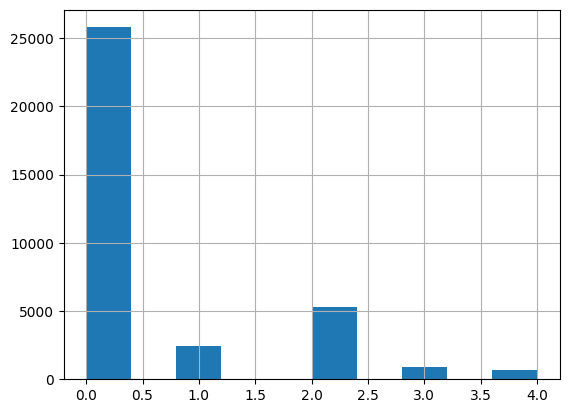

In [2]:
# Ensure plots are displayed inline in the notebook
%matplotlib inline

from matplotlib import pyplot as plt # showing and rendering figures 

# Display plot
df_labels['level'].hist()

# Number of images to each label
df_labels['level'].value_counts()


Como observamos en la grafica tenemos un total de `35108` imagenes en total, distribuidas en 5 clases.  

Además, de acuerdo con los datos debemos tener en cuenta lo siguiente:
* tenemos imagenes de ambos ojos por paciente, esto al mostrarse en las etiquetas si es una imagen de un ojo izquierdo o derecho.
* el archivo muestra las etiquetas de los ojo, pero debemos comprobar su existencia en el directorio, para ello debemos armar su direccion.

Posterior a ello, debemos relizar un balanceo de datos entre cada clase asi como una separacion en datos de entranamiento y datos de validacion para el modelo a entrenar. sin olvidar el preprocesamiento.

* Imbalanced Classification with Multiple Classes

In [61]:
from skimage.io import imread
from glob import glob

base_image_dir = os.path.join('C:\\Users\\FINSUS-Admin\\Documents\\gblasd\\DDRUCNN','data')
# print(base_image_dir)
retina_df = pd.read_csv(os.path.join(base_image_dir,'trainLabels_cropped.csv'))
# print(os.path.join(base_image_dir, 'trainLabels_cropped.csv'))

# Get number of patient
retina_df['PatientId'] =  retina_df['image'].map(lambda x: x.split('_')[0])
# get path of the image
retina_df['path'] = retina_df['image'].map(lambda x: os.path.join(base_image_dir, 'resized_train_cropped', '{}.jpeg'.format(x)))
# We check if the image exists in the directory
retina_df['exists'] = retina_df['path'].map(os.path.exists)

print(retina_df['exists'].sum(), ' images found of ', retina_df.shape[0], ' total')

# 0 if it is right eye, 1 if it is opposite
retina_df['eye'] = retina_df['image'].map(lambda x: 1 if x.split('_')[-1] == 'left' else 0)

retina_df

35108  images found of  35108  total


,image,level,PatientId,path,exists,eye
0,10_left,0,10,C:\Users\FINSUS-Admin\Documents\gblasd\DDRUCNN...,True,1
1,10_right,0,10,C:\Users\FINSUS-Admin\Documents\gblasd\DDRUCNN...,True,0
2,13_left,0,13,C:\Users\FINSUS-Admin\Documents\gblasd\DDRUCNN...,True,1
3,13_right,0,13,C:\Users\FINSUS-Admin\Documents\gblasd\DDRUCNN...,True,0
4,15_left,1,15,C:\Users\FINSUS-Admin\Documents\gblasd\DDRUCNN...,True,1
...,...,...,...,...,...,...
35103,44347_right,0,44347,C:\Users\FINSUS-Admin\Documents\gblasd\DDRUCNN...,True,0
35104,44348_left,0,44348,C:\Users\FINSUS-Admin\Documents\gblasd\DDRUCNN...,True,1
35105,44348_right,0,44348,C:\Users\FINSUS-Admin\Documents\gblasd\DDRUCNN...,True,0
35106,44349_left,0,44349,C:\Users\FINSUS-Admin\Documents\gblasd\DDRUCNN...,True,1


In [66]:
from keras.utils.np_utils import to_categorical # Converts a class vector (integers) to binary class matrix.

retina_df['level_cat'] = retina_df['level'].map(lambda x: to_categorical(x, 1+retina_df['level'].max()))
retina_df.dropna(inplace=True) # Remove missing values.
retina_df = retina_df[retina_df['exists']] # add columns
retina_df.sample(5) # Return a random sample of items from an axis of object.



,image,level,PatientId,path,exists,eye,level_cat
32445,40974_right,0,40974,C:\Users\FINSUS-Admin\Documents\gblasd\DDRUCNN...,True,0,"[1.0, 0.0, 0.0, 0.0, 0.0]"
14154,17785_right,1,17785,C:\Users\FINSUS-Admin\Documents\gblasd\DDRUCNN...,True,0,"[0.0, 1.0, 0.0, 0.0, 0.0]"
11271,14160_left,2,14160,C:\Users\FINSUS-Admin\Documents\gblasd\DDRUCNN...,True,1,"[0.0, 0.0, 1.0, 0.0, 0.0]"
29355,37183_right,0,37183,C:\Users\FINSUS-Admin\Documents\gblasd\DDRUCNN...,True,0,"[1.0, 0.0, 0.0, 0.0, 0.0]"
24,31_left,0,31,C:\Users\FINSUS-Admin\Documents\gblasd\DDRUCNN...,True,1,"[1.0, 0.0, 0.0, 0.0, 0.0]"


### Eaminamos la distribucion de la severidad en los ojos

array([[<Axes: title={'center': 'level'}>,
        <Axes: title={'center': 'eye'}>]], dtype=object)

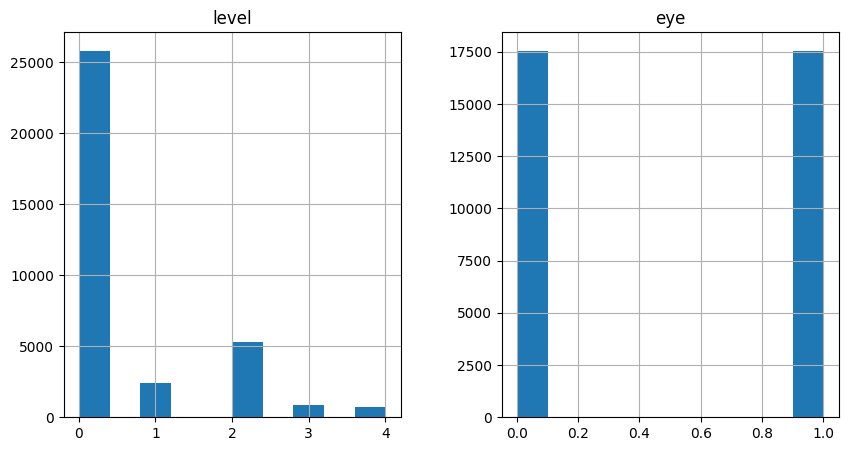

In [67]:
retina_df[['level', 'eye']].hist(figsize=(10,5))

### Separamos datos en bloque de entrenamiento y validación


In [68]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras import backend as K
from keras.applications.vgg16 import preprocess_input


In [72]:
rr_df = retina_df[['PatientId', 'level']].drop_duplicates() # Return DataFrame with duplicate rows removed.

# Split arrays or matrices into random train and test subsets.
train_ids, valid_ids = train_test_split(rr_df['PatientId'],         # arrays
                                        test_size=0.20,             # test_size
                                        train_size=0.80,            # train_size
                                        random_state=2018,          # check (Controls the shuffling applied to the data before applying the split. )
                                        stratify=rr_df['level'])    # labels of class

raw_train_df = retina_df[retina_df['PatientId'].isin(train_ids)]    # Whether each element in the DataFrame is contained in values.
valid_df = retina_df[retina_df['PatientId'].isin(valid_ids)]

print('train', raw_train_df.shape[0], ' validation ', valid_df.shape[0])

train 28797  validation  7671


### Balanceamos la distribucion del set de entrenamiento

New Data Size:  720  Old size:  27138


array([[<Axes: title={'center': 'level'}>,
        <Axes: title={'center': 'eye'}>]], dtype=object)

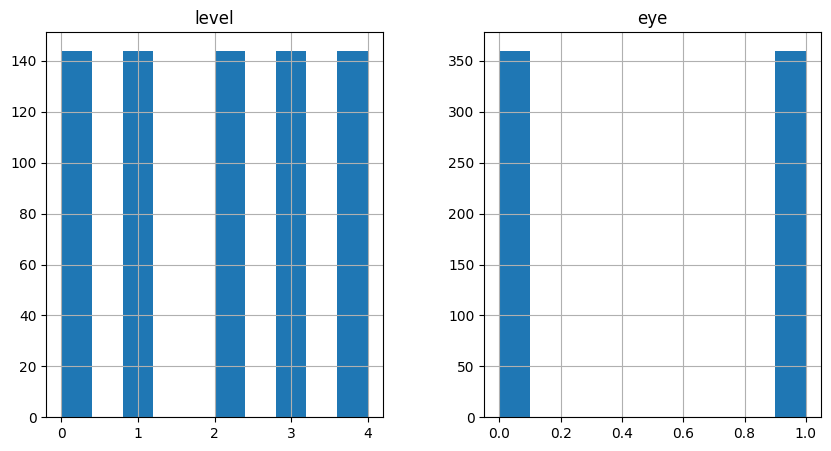

In [45]:
train_df = raw_train_df.groupby(['level', 'eye']).apply(lambda x: x.sample(72, replace=True)).reset_index(drop=True)
print('New Data Size: ', train_df.shape[0], ' Old size: ', raw_train_df.shape[0])
train_df[['level', 'eye']].hist(figsize=(10,5))